# Machine Learning LAB 1 
Course 2022/23: F. Barbato, M. Mel, P. Zanuttigh

The notebook contains some simple tasks to be performed about **classification and regression**. <br>
Complete all the **required code sections** and **answer to all the questions**. <br>

### IMPORTANT for the evaluation score:
1. **Read carefully all cells** and **follow the instructions**
1. **Rerun all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
2. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
3. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command** - otherwise points will be deduced.
4. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## A) Classification of Day/Night

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB1.ipynb** otherwise your homework could get lost
<br>

**Student name**: Nicolò Lai<br>
**ID Number**: 2090566

### Dataset description

The data was recorded using the new **Luxottica I-SEE glasses** in exterior conditions. These devices provide multiple **sensors mounted inside the glasses**, which can be accessed through a bluetooth connection. <br>
For the **classification** part of the notebook we will focus on the **UVA**, **UVB** and **pressure** sensors, with the goal of discriminating between **day and night** time.

![I-SEE Glasses](data/isee.png "I-SEE")

We first **import** all **the packages** that are needed.

In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
import itertools

import warnings
warnings.filterwarnings("ignore")

Change some global settings for layout purposes.

In [2]:
# if you are in the jupyter notebook environment you can change the 'inline' option with 'notebook' to get interactive plots
%matplotlib inline
# change the limit on the line length and crop to 0 very small numbers, for clearer printing
np.set_printoptions(linewidth=500, suppress=True)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.facecolor'] = 'white'

## A.1) Perceptron
In the following cells we will **implement** the **perceptron** algorithm and use it to learn a halfspace.

**TO DO (A.1.0):** **Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [3]:
IDnumber = 2090566 # YOUR_ID
np.random.seed(IDnumber)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (the **training** set is **typically larger**, here we use a 75% training 25% test split).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above. Try different seeds to evaluate the impact of randomization.<br><br>
**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [4]:
def load_dset(filename, features=[2,3,9], label_id=-1, mode='clas'):
    # Load the dataset
    with open(filename, newline='\n') as f:
        raw_data = csv.reader(f, delimiter=',')
        header = next(raw_data)                # skip first line
        print(f"Header: {header}\n")

        dataset = np.array(list(raw_data))
        print(f"Data shape: {dataset.shape}\n")
        print("Dataset Example:")
        print(dataset[0,...])                  # print the first row of the dataset

    X = dataset[:,features].astype(float)      # extract the selected features, default refers to the first part of the lab: [uva, uvb, pressure]
    if mode == 'clas':
        Y = dataset[:,label_id].astype(int)    # if we are in classification mode, get the labels from the provided index as indices
        Y = 2*Y-1                              # for the perceptron night --> -1, day --> 1
    else:
        Y = dataset[:,label_id].astype(float)  # otherwise get them as floats

    m = dataset.shape[0]
    print("\nNumber of samples loaded:", m)
    permutation = np.random.permutation(m)     # random permutation

    X = X[permutation]
    Y = Y[permutation]
    
    return X, Y

In [5]:
# Load the dataset
X, Y = load_dset('data/lux.csv')

Header: ['rh', 'temp', 'uva', 'uvb', 'x', 'y', 'blueg', 'blueb', 'worn', 'pressure', 'timestamp', 'hour', 'minute', 'second', 'isnight']

Data shape: (2177, 15)

Dataset Example:
['23.846666666666668' '37.21333333333334' '5.577416666666666' '1.6235333333333333' '615.7777777777778' '686.0' '134.0' '117.0' '0.0' '1.000291690654385' '1650458376' '14' '39' '36' '0']

Number of samples loaded: 2177


We are going to differentiate (classify) between **class "1" (day)** and **class "-1" (night)**

# Split data in training and test sets



Given $m$ total data, denote with $m_{t}$ the part used for training. Keep $m_t$ data as training data, and $m_{test}:= m-m_{t}$. <br>
For instance one can take $m_t=0.75m$ of the data as training and $m_{test}=0.25m$ as testing. <br>
Let us define as define

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

TESTING DATA: The test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$

**TO DO (A.1.1):** **Divide** the **data into training and test set** (**75%** of the data in the **first** set, **25%** in the **second** one). <br>
<br>
Notice that as is common practice in Statistics and Machine Learning, **we scale the data** (= each variable) so that it is centered **(zero mean)** and has **standard deviation equal to 1**. <br>
This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients.

In [6]:
# compute the splits
m_training = int(0.75*X.shape[0])

# m_test is the number of samples in the test set (total-training)
m_test = X.shape[0] - m_training

# X_training = instances for training set
X_training = X[:m_training]
# Y_training = labels for the training set
Y_training = Y[:m_training]

# X_test = instances for test set
X_test = X[m_training:]
# Y_test = labels for the test set
Y_test = Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training = scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test = scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 1632
Number of samples in the test set: 545

Number of night instances in test: 265
Number of day instances in test: 280
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [ 0.01733134  0.01300155 -0.01449449]
Std of the test input data: [1.08390781 1.04856613 1.00655317]


We **add a 1 in front of each sample** so that we can use a vector in **homogeneous coordinates** to describe all the coefficients of the model. This can be done with the function $hstack$ in $numpy$.

In [6]:
def to_homogeneous(X_training, X_test):
    # Add a 1 to each sample (homogeneous coordinates)
    X_training = np.hstack( [np.ones( (X_training.shape[0], 1) ), X_training] )
    X_test     = np.hstack( [np.ones( (X_test.shape[0], 1) ), X_test] )
    
    return X_training, X_test

In [8]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.          1.28756241  1.18331842  0.29004587]
 [ 1.          0.80731825  0.73575721  0.1460155 ]
 [ 1.         -0.46243796 -0.44622677 -0.63672108]
 [ 1.          1.76244722  1.60670054  0.38515697]
 [ 1.         -0.46005098 -0.456295   -0.60292219]
 [ 1.         -0.47510734 -0.45919558 -0.35528149]
 [ 1.         -0.46599286 -0.45589808  1.51812805]
 [ 1.         -0.04430295 -0.05702407 -1.55757342]
 [ 1.          1.00195245  0.92895838  1.80191924]
 [ 1.         -0.47752711 -0.46125651 -0.81016339]]


**TO DO (A.1.2):** Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout .

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

In [9]:
def count_errors(current_w, X, Y):
    # This function:
    # computes the number of misclassified samples
    # returns the index of the first misclassified sample
  
    # pred must have the same shape as Y, hint: pred = np.sign( ... )
    pred = np.sign(Y * np.dot(X, current_w)) 
    
    # wrong has the same shape as pred and Y, contains boolean values          
    wrong = pred <= 0
    
    # num_misclassified contains the number of wrong predictions
    num_misclassified = wrong.sum()             
    
    if num_misclassified > 0:
        index_misclassified = np.where(wrong)[0][0]
    else:
        index_misclassified = -1 # signaling value for termination
    
    return num_misclassified, index_misclassified
        
def perceptron_update(current_w, x, y):
    # Place in this function the update rule of the perceptron algorithm
    # Remember that numpy arrays can be treated as generalized variables
    # therefore given array a = [1,2,3,4], the operation b = 10*a will yield
    # b = [10, 20, 30, 40]
    new_w = current_w + y*x
    return new_w

def perceptron(X, Y, max_num_iterations):
    
    # Initialize some support variables
    num_samples = X.shape[0]
    # best_errors will keep track of the best (minimum) number of errors
    # seen throughout training, used for the update of the best_w variable
    best_error = num_samples+1

    # error history will keep track of the number of errors at each iteration
    error_history = []
    
    # Initialize the weights of the algorith with w=0
    curr_w = np.zeros(X.shape[1]) 
    # The best_w variable will be used to keep track of the best solution
    best_w = curr_w.copy()

    # compute the number of misclassified samples and the index of the first of them
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
            
    # update the 'best' variables
    if num_misclassified < best_error:
        best_error = num_misclassified 
        best_w = curr_w 
        
    # initialize the number of iterations
    num_iter = 0
    
    # Main loop continue until all samples correctly classified or max # iterations reached
    # Remember that to signify that no errors were found we set index_misclassified = -1
    while index_misclassified != -1 and num_iter < max_num_iterations:
        
        # save the current error in the error history
        error_history.append(num_misclassified/num_samples)
        
        # Call the perceptron_update function using the found misclassified sample
        curr_w = perceptron_update(curr_w, X[index_misclassified], Y[index_misclassified])
        
        # permute the dataset 
        # **IMPORTANT** use the SAME permutation for samples and labels
        per = np.random.permutation(num_samples)
        X = X[per]
        Y = Y[per]
        
        # repeat the error count and best variables update
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        
        # update the 'best' variables
        if num_misclassified < best_error:
            best_error = num_misclassified  
            best_w = curr_w 
        
        # update the iteration number
        num_iter += 1

    # as required, return the best error as a ratio with respect to the total number of samples
    best_error = best_error/num_samples  
    
    return best_w, best_error, np.array(error_history)


Now we use the implementation above of the perceptron to learn a model from the training data using 100 iterations and print the error of the best model we have found.

In [19]:
# Now run the perceptron for 100 iterations
n_iterations = 100
w_found, error, error_history = perceptron(X_training, Y_training, n_iterations)
print("Training Error of perceptron (100 iterations): " + str(error))

Training Error of perceptron (100 iterations): 0.028799019607843136


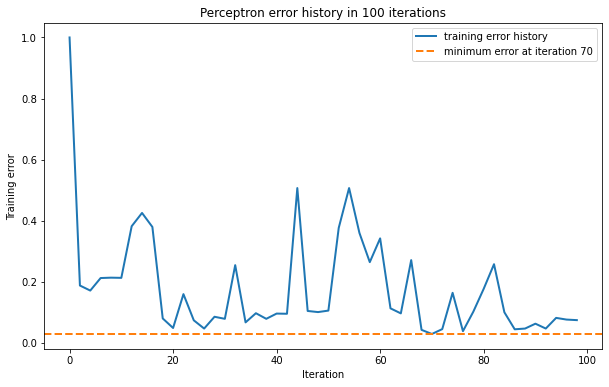

In [27]:
# plot error history (number of misclassified samples at each iteration)
fig = plt.figure()
ax = fig.add_subplot(111)

# skip some iterations to make the plot more readable
skip = 2

# plot the error history
ax.plot(
    np.arange(0, n_iterations)[::skip], 
    error_history[::skip],
    lw = 2,
    label = "training error history"
)

# plot the best error found
ax.axhline(error_history.min(), color='tab:orange', lw=2, ls="dashed", label=f"minimum error at iteration {error_history.argmin()}")

ax.legend()


ax.set_title(f"Perceptron error history in {n_iterations} iterations")
ax.set_xlabel("Iteration")
ax.set_ylabel("Training error")

plt.show()

**TO DO (A.1.3):** use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [28]:
num_errors, _ = count_errors(w_found, X_test, Y_test)

# Error rate on the test set
true_loss_estimate = num_errors/m_test
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate))

Test Error of perceptron (100 iterations): 0.025688073394495414


**TO DO (A.Q1) [Answer the following]** <br>
What about the difference between the training error and the test error  in terms of fraction of misclassified samples? Explain what you observe. (Notice that with a very small dataset like this one results can change due to randomization, try to run with different random seeds if you get unexpected results).

<div class="alert alert-block alert-info">
**ANSWER A.Q1**:<br>
answer here
 </div>

**TO DO (A.1.4):** Copy the code from the last 2 cells above in the cell below and repeat the training with 3000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [69]:
n_iterations = 3000

w_found, error, error_history = perceptron(X_training, Y_training, n_iterations)
print("Training Error of perceptron (3000 iterations): " + str(error))

num_errors, _ =  count_errors(w_found, X_test, Y_test)

true_loss_estimate = num_errors/m_test
print("Test Error of perceptron (3000 iterations): " + str(true_loss_estimate))

Training Error of perceptron (3000 iterations): 0.026348039215686275
Test Error of perceptron (3000 iterations): 0.03486238532110092


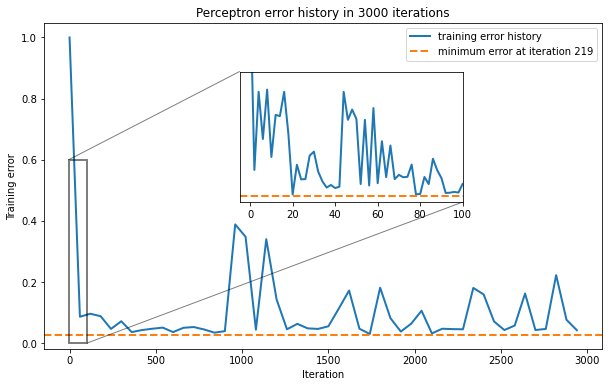

In [71]:
# plot error history (number of misclassified samples at each iteration)
fig = plt.figure()
ax = fig.add_subplot(111)

# skip some iterations to make the plot more readable
skip = 60

# plot the error history
ax.plot(
    np.arange(0, n_iterations)[::skip], 
    error_history[::skip],
    lw = 2,
    label = "training error history"
)

# plot the best error found
ax.axhline(error_history.min(), color='tab:orange', lw=2, ls="dashed", label=f"minimum error at iteration {error_history.argmin()}")

# make an inset plot showing the first 100 iterations
ax_ins = ax.inset_axes([0.35, 0.45, 0.4, 0.4])

# plot the error history in the inset
ax_ins.plot(np.arange(0, n_iterations)[::2], error_history[::2], lw = 2)

# plot the best error found in the inset
ax_ins.axhline(error_history.min(), color='tab:orange', lw=2, ls="dashed", label=f"minimum error at iteration {error_history.argmin()}")

ax_ins.set_xlim(-5, 100)
ax_ins.set_ylim(0, 0.6)
ax_ins.set_yticks([])

# mark the region corresponding to the inset plot
ax.indicate_inset_zoom(ax_ins, edgecolor="black", lw=2)

# show the legend
ax.legend()

ax.set_title(f"Perceptron error history in {n_iterations} iterations")
ax.set_xlabel("Iteration")
ax.set_ylabel("Training error")

plt.show()

In [140]:
def run_multiple_perceptrons(X, Y, n_iterations, n_runs):
    best_errors = []
    weights = []
    for _ in range(n_runs):
        w_found, error, _ = perceptron(X, Y, n_iterations)
        best_errors.append(error)
        weights.append(w_found)
    return np.array(best_errors), np.array(weights)

def test_multiple_perceptrons(X, Y, weights):
    test_errors = []
    for w in weights:
        num_errors, _ =  count_errors(w, X, Y)
        test_errors.append(num_errors/len(Y))
    return np.array(test_errors)

In [137]:
# run the perceprton algorithm with 100 iterations multiple times and save the best error found each time
n_runs = 100

n_iterations = 100
best_errors_100, weights_100 = run_multiple_perceptrons(X_training, Y_training, n_iterations, n_runs)

# run the perceprton algorithm with 3000 iterations multiple times and save the best error found each time
n_runs = 100

n_iterations = 3000
best_errors_3000, weights_3000 = run_multiple_perceptrons(X_training, Y_training, n_iterations, n_runs)

# evaluate the test error for each of the weights found
test_errors_100  = test_multiple_perceptrons(X_test, Y_test, weights_100)
test_errors_3000 = test_multiple_perceptrons(X_test, Y_test, weights_3000)

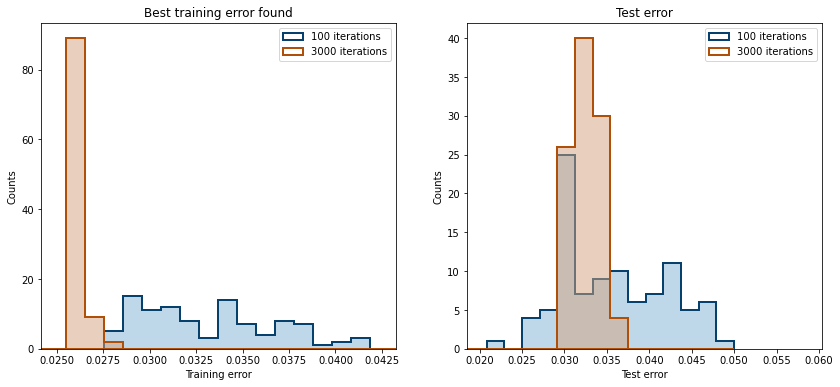

In [153]:
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121)

ax1.hist(best_errors_100,  bins=np.linspace(0, 0.05, 50), color="#7eb0d5", lw=2, alpha=0.5)
ax1.hist(best_errors_100,  bins=np.linspace(0, 0.05, 50), histtype="stepfilled", edgecolor="#06416D", facecolor="none", lw=2, label="100 iterations")
ax1.hist(best_errors_3000, bins=np.linspace(0, 0.05, 50), color="#d5a37e", lw=2, alpha=0.5)
ax1.hist(best_errors_3000, bins=np.linspace(0, 0.05, 50), histtype="stepfilled", edgecolor="#B05008", facecolor="none", lw=2, label="3000 iterations")
ax1.legend()


mmin = min(best_errors_100.min(), best_errors_3000.min())
mmax = max(best_errors_100.max(), best_errors_3000.max())
ax1.set_xlim(left=mmin - (mmax-mmin)*0.1, right=mmax + (mmax-mmin)*0.1)

ax1.set_title("Best training error found")
ax1.set_xlabel("Training error")
ax1.set_ylabel("Counts")

ax2 = fig.add_subplot(122)

ax2.hist(test_errors_100,  bins=np.linspace(0, 0.05, 25), color="#7eb0d5", lw=2, alpha=0.5)
ax2.hist(test_errors_100,  bins=np.linspace(0, 0.05, 25), histtype="stepfilled", edgecolor="#06416D", facecolor="none", lw=2, label="100 iterations")
ax2.hist(test_errors_3000, bins=np.linspace(0, 0.05, 25), color="#d5a37e", lw=2, alpha=0.5)
ax2.hist(test_errors_3000, bins=np.linspace(0, 0.05, 25), histtype="stepfilled", edgecolor="#B05008", facecolor="none", lw=2, label="3000 iterations")
ax2.legend()


mmin = min(test_errors_100.min(), test_errors_3000.min())
mmax = max(test_errors_100.max(), test_errors_3000.max())
ax2.set_xlim(left=mmin - (mmax-mmin)*0.1, right=mmax + (mmax-mmin)*0.1)

ax2.set_title("Test error")
ax2.set_xlabel("Test error")
ax2.set_ylabel("Counts")

plt.show()

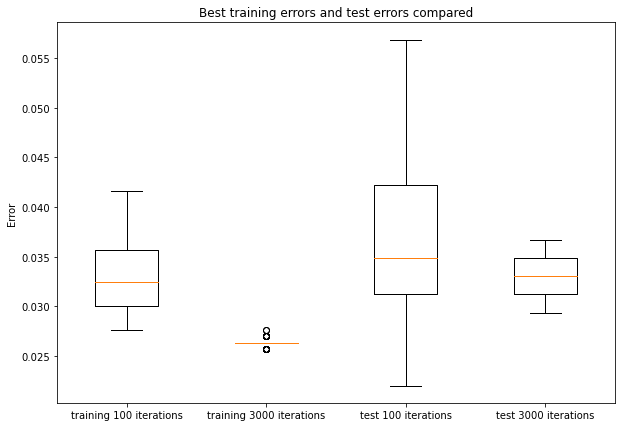

In [163]:
# make a boxplot between 100 and 3000 iterations
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
ax.boxplot(
    [best_errors_100, best_errors_3000, test_errors_100, test_errors_3000], 
    labels=["training 100 iterations", "training 3000 iterations", "test 100 iterations", "test 3000 iterations"],

)

ax.set_title("Best training errors and test errors compared")
ax.set_ylabel("Error")
plt.show()

**TO DO (A.Q2) [Answer the following]** <br>
What about the difference between the training error and the test error in terms of the fraction of misclassified samples) when running for a larger number of iterations? Explain what you observe and compare with the previous case.

<div class="alert alert-block alert-info">
**ANSWER A.Q2**:<br>
answer here
</div>

# A.2) Logistic Regression
Now we use **logistic regression**, exploiting the implementation in **Scikit-learn**, to predict labels. We will also plot the decision boundaries of logistic regression.

We first load the dataset again.

In [6]:
# Load the dataset
X, Y = load_dset('data/lux.csv')

Header: ['rh', 'temp', 'uva', 'uvb', 'x', 'y', 'blueg', 'blueb', 'worn', 'pressure', 'timestamp', 'hour', 'minute', 'second', 'isnight']

Data shape: (2177, 15)

Dataset Example:
['23.846666666666668' '37.21333333333334' '5.577416666666666' '1.6235333333333333' '615.7777777777778' '686.0' '134.0' '117.0' '0.0' '1.000291690654385' '1650458376' '14' '39' '36' '0']

Number of samples loaded: 2177


**TO DO (A.2.1):** As for the previous part, **divide the data** into training and test (75%-25%) and **add a 1 as first component** to each sample.

In [9]:
# compute the splits
m_training = int(0.75 * X.shape[0])

# m_test is the number of samples in the test set (total-training)
m_test = X.shape[0] - m_training

# X_training = instances for training set
X_training = X[:m_training]
# Y_training = labels for the training set
Y_training = Y[:m_training]

# X_test = instances for test set
X_test = X[m_training:]
# Y_test = labels for the test set
Y_test = Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training = scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test = scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

# convert to homogeneous coordinates
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Number of samples in the train set: 1632
Number of samples in the test set: 545

Number of night instances in test: 265
Number of day instances in test: 280
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [ 0.01733134  0.01300155 -0.01449449]
Std of the test input data: [1.08390781 1.04856613 1.00655317]
Training set in homogeneous coordinates:
[[ 1.          1.28756241  1.18331842  0.29004587]
 [ 1.          0.80731825  0.73575721  0.1460155 ]
 [ 1.         -0.46243796 -0.44622677 -0.63672108]
 [ 1.          1.76244722  1.60670054  0.38515697]
 [ 1.         -0.46005098 -0.456295   -0.60292219]
 [ 1.         -0.47510734 -0.45919558 -0.35528149]
 [ 1.         -0.46599286 -0.45589808  1.51812805]
 [ 1.         -0.04430295 -0.05702407 -1.55757342]
 [ 1.          1.00195245  0.92895838  1.80191924]
 [ 1.         -0.47752711 -0.46125651 -0.81016339]]


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. <br>
See the Scikit-learn documentation for how to use it [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**TO DO (A.2.2):** **Define** the **logistic regression** model, then **learn** the model using **the training set** and **predict** on the **test set**. Then **print** the **fraction of samples misclassified** in the training set and in the test set.

In [10]:
# part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5)

# learn from training set: hint use fit(...)
logreg.fit(X_training, Y_training)

print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on training set
predicted_training = logreg.predict(X_training)

# print the error rate = fraction of misclassified samples
error_count_training = (predicted_training != Y_training).sum()
error_rate_training = error_count_training/m_training
print("Error rate on training set: "+str(error_rate_training))

# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()
error_rate_test = error_count_test/m_test
print("Error rate on test set: " + str(error_rate_test))

Intercept: [-6.42214282]
Coefficients: [[ -6.37532362  38.49864353 -77.08921118   0.96099503]]
Error rate on training set: 0.03370098039215686
Error rate on test set: 0.03853211009174312


**TO DO (A.2.3)** Now **pick two features** and restrict the dataset to include only two features, whose indices are specified in the $idx0$ and $idx1$ variables below. Then split into training and test.

In [189]:
# we define some additional variables:
#    feature_names  == name to display on the plots
#    feature_scales == scale (linear/log) to use for that metric
# this will be referred to in the following cell - to plot the values
feature_names  = ["UVA", "UVB", "Atm. Pressure"]
feature_scales = ["log", "log", "linear"]

# remember that we selected 3 sensors (uva, uvb, pressure), therefore
# to make the plot we need to reduce the data to 2D, so we choose two of them
# to do so change the following indices (between 0 and 2, inclusive)
idx0 = 1
idx1 = 0

X_reduced = X[:,[idx0, idx1]]

# re-initialize the dataset splits, with the reduced sets
X_training = X_reduced[:m_training]
Y_training = Y[:m_training]

X_test = X_reduced[m_training:]
Y_test = Y[m_training:]

Now learn a model using the training data and measure the performances.

In [190]:
# learning from training data
logreg.fit(X_training, Y_training)

# print the error rate = fraction of misclassified samples
error_rate_training = (logreg.predict(X_training) != Y_training).sum()/m_training
error_rate_test     = (logreg.predict(X_test) != Y_test).sum()/m_test


print("Error rate on training set: " + str(error_rate_training))
print("Error rate on test set: " + str(error_rate_test))

Error rate on training set: 0.034926470588235295
Error rate on test set: 0.04036697247706422


In the next cell I will train the classifier on every combination of two features.

In [186]:
def train_classifier(X, Y, C=1e5):
    logreg = linear_model.LogisticRegression(C=C)
    logreg.fit(X, Y)
    return logreg

def compute_error_rate(X, Y, classifier):
    return (classifier.predict(X) != Y).sum()/X.shape[0]

# make all possible combination of features
feature_combinations = list(itertools.combinations(range(3), 2))

for comb in feature_combinations:
    
    print("Combination of features:", feature_names[comb[0]], "and", feature_names[comb[1]])

    X_reduced  = X[:,comb]
    X_training = X_reduced[:m_training]
    Y_training = Y[:m_training]
    X_test     = X_reduced[m_training:]
    Y_test     = Y[m_training:]

    logreg = train_classifier(X_training, Y_training)

    error_rate_train = compute_error_rate(X_training, Y_training, logreg)
    error_rate_test  = compute_error_rate(X_test, Y_test, logreg)

    print(f"Error rate on training set: {error_rate_train:.5f}")
    print(f"Error rate on test set: {error_rate_test:.5f}")
    print()

Combination of features: UVA and UVB
Error rate on training set: 0.03493
Error rate on test set: 0.04037

Combination of features: UVA and Atm. Pressure
Error rate on training set: 0.03554
Error rate on test set: 0.04404

Combination of features: UVB and Atm. Pressure
Error rate on training set: 0.03370
Error rate on test set: 0.04037



**TO DO (A.Q3) [Answer the following]** <br>
Which features did you select and why? <br>
Compare the perfomance of the classifiers trained with every combination of two features with that of the baseline (which used all 3 features).

<div class="alert alert-block alert-info">
**ANSWER A.Q3**:<br>
answer here
</div>

If everything is ok, the code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

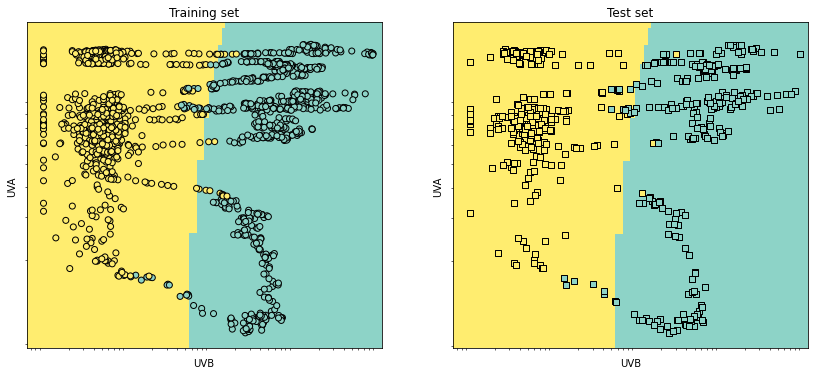

In [194]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
y_min, y_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()
xx, yy = np.meshgrid(
    np.linspace(x_min-(x_max-x_min)*0.25, x_max+(x_max-x_min)*0.25, 1000), 
    np.linspace(y_min-(y_max-y_min)*0.25, y_max+(y_max-y_min)*0.25, 1000)
)

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# shift all the values to positive, to avoid problems with log-log plots
shift = .001 - X_reduced.min(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].pcolormesh(xx + shift[0], yy + shift[1], Z, cmap=plt.cm.Set3)
axs[1].pcolormesh(xx + shift[0], yy + shift[1], Z, cmap=plt.cm.Set3)

# Plot also the training points
axs[0].scatter(X_training[:, 0] + shift[0], X_training[:, 1] + shift[1], c=Y_training, edgecolors='k', cmap=plt.cm.Set3)

axs[0].set_xlabel(feature_names[idx0])
axs[0].set_ylabel(feature_names[idx1])
axs[0].set_xscale(feature_scales[idx0])
axs[0].set_yscale(feature_scales[idx1])

axs[0].set_xlim(xx.min() + shift[0], xx.max() + shift[0])
axs[0].set_ylim(yy.min() + shift[1], yy.max() + shift[1])
axs[0].set_xticks(())
axs[0].set_yticks(())
axs[0].set_title('Training set')

# Plot also the test points 
axs[1].scatter(X_test[:, 0] + shift[0], X_test[:, 1] + shift[1], c=Y_test, edgecolors='k', cmap=plt.cm.Set3, marker='s')
axs[1].set_xlabel(feature_names[idx0])
axs[1].set_ylabel(feature_names[idx1])
axs[1].set_xscale(feature_scales[idx0])
axs[1].set_yscale(feature_scales[idx1])

axs[1].set_xlim(xx.min() + shift[0], xx.max() + shift[0])
axs[1].set_ylim(yy.min() + shift[1], yy.max() + shift[1])
axs[1].set_xticks(())
axs[1].set_yticks(())
axs[1].set_title('Test set')

plt.show()

In the next cell I will plot the decision boundary for all the combination of features to better compare them.

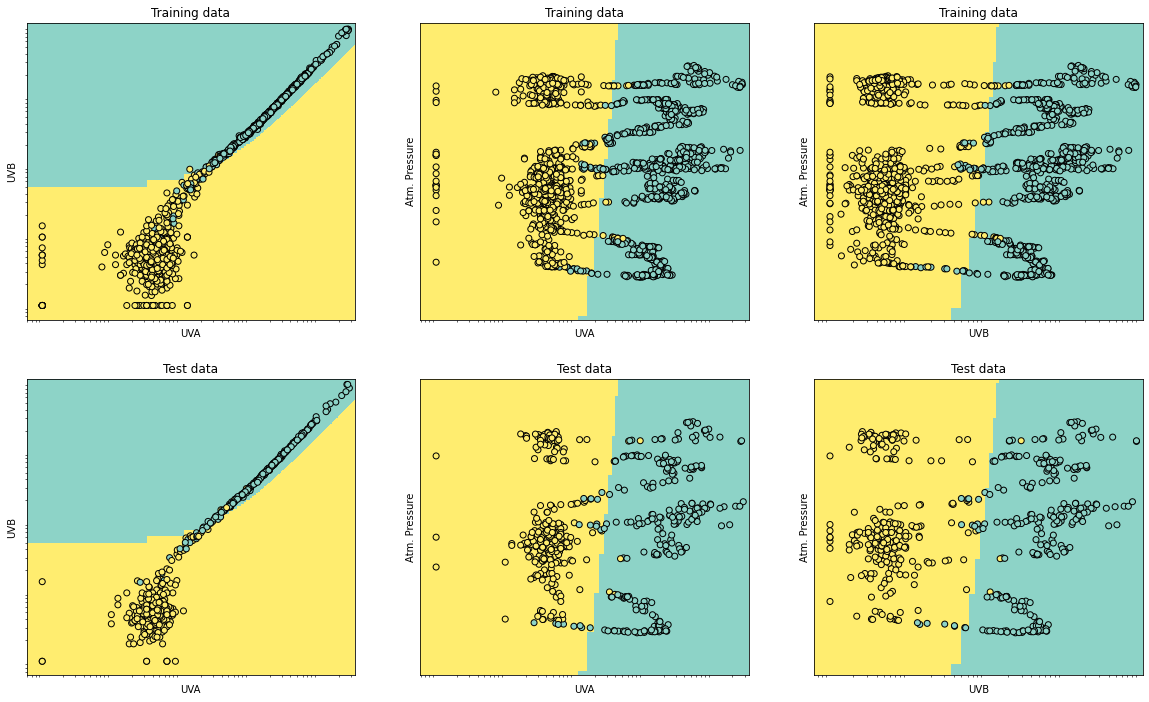

In [212]:
def create_limits(X, idx0, idx1):
    """Create the limits for the meshgrid"""
    min0 = np.min(X[:,idx0])
    max0 = np.max(X[:,idx0])
    min1 = np.min(X[:,idx1])
    max1 = np.max(X[:,idx1])
    return min0, max0, min1, max1

def create_meshgrid(X, idx0, idx1, n=500, margin=0.1):
    """Create the meshgrid for prediction grid"""
    min0, max0, min1, max1 = create_limits(X, idx0, idx1)
    x0, x1 = np.meshgrid(
        np.linspace(min0-(max0-min0)*margin, max0+(max0-min0)*margin, n), 
        np.linspace(min1-(max1-min1)*margin, max1+(max1-min1)*margin, n)
    )
    return x0, x1

def create_pcolormesh(fig, id, x0, x1, Z, ax=None):
    """Create the pcolormesh depicting the decion boundary"""
    if ax is None:
        ax = fig.add_subplot(id)
    ax.pcolormesh(x0, x1, Z, cmap=plt.cm.Set3)
    return ax

def create_scatter(fig, id, x0, x1, Y, ax=None):
    """Create the scatter plot of data points"""
    if ax is None:
        ax = fig.add_subplot(id)
    ax.scatter(x0, x1, c=Y, edgecolors='k', cmap=plt.cm.Set3)
    return ax

def customize_plot(ax, idx0, idx1, feature_names, feature_scales):
    """Plot customization"""
    ax.set_xlabel(feature_names[idx0])
    ax.set_ylabel(feature_names[idx1])
    ax.set_xscale(feature_scales[idx0])
    ax.set_yscale(feature_scales[idx1])
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def set_axis_limits(ax, x0, x1):
    """Set the axis limits"""
    ax.set_xlim(x0.min(), x0.max())
    ax.set_ylim(x1.min(), x1.max())
    return ax

fig = plt.figure(figsize=(20, 12))

# loop over all possible pairs of features
for i, comb in enumerate(feature_combinations):

    # select the two features
    X_reduced  = X[:,comb]
    X_training = X_reduced[:m_training]
    Y_training = Y[:m_training]
    X_test     = X_reduced[m_training:]
    Y_test     = Y[m_training:]

    # train the model
    logreg = train_classifier(X_training, Y_training)

    # create the meshgrid
    x0, x1 = create_meshgrid(X_reduced, 0, 1, n=1000, margin=0.2)
    
    # predict the values on the meshgrid
    pred = logreg.predict(np.c_[x0.ravel(), x1.ravel()]).reshape(x0.shape)

    # shift to positive values
    shift = .001 - X_reduced.min(axis=0)
        
    # create the pcolormesh
    ax1 = create_pcolormesh(fig, 231+i, x0 + shift[0], x1 + shift[1], pred)
    ax2 = create_pcolormesh(fig, 234+i, x0 + shift[0], x1 + shift[1], pred)
    
    # create the scatter plot
    ax1 = create_scatter(fig, 231+i, X_training[:,0] + shift[0], X_training[:,1] + shift[1], Y_training, ax=ax1)
    ax2 = create_scatter(fig, 234+i, X_test[:,0] + shift[0], X_test[:,1] + shift[1], Y_test, ax=ax2)
    
    # customize the plot
    ax1 = customize_plot(ax1, comb[0], comb[1], feature_names, feature_scales)
    ax2 = customize_plot(ax2, comb[0], comb[1], feature_names, feature_scales)
    
    # set the axis limits
    ax1 = set_axis_limits(ax1, x0 + shift[0], x1 + shift[1])
    ax2 = set_axis_limits(ax2, x0 + shift[0], x1 + shift[1])

    ax1.set_title("Training data")
    ax2.set_title("Test data")

    
plt.show()

# B) Linear Regression on the Atmospheric Conditions

As before, these **samples** were **extracted from** a Luxottica **I-SEE** device. <br>
For the **second part** of the laboratory we will **focus on linear regression**. We will try to estimate the **relative humidity** starting from **temperature** and **atmospheric pressure**.

First of all, we load again the dataset. Notice that the indices of the features were changed!

In [7]:
# Load the dataset
X, Y = load_dset('data/lux.csv', [0,1], 9, mode='reg')

Header: ['rh', 'temp', 'uva', 'uvb', 'x', 'y', 'blueg', 'blueb', 'worn', 'pressure', 'timestamp', 'hour', 'minute', 'second', 'isnight']

Data shape: (2177, 15)

Dataset Example:
['23.846666666666668' '37.21333333333334' '5.577416666666666' '1.6235333333333333' '615.7777777777778' '686.0' '134.0' '117.0' '0.0' '1.000291690654385' '1650458376' '14' '39' '36' '0']

Number of samples loaded: 2177


**TO DO (B.1)**: split the data in training and test sets (70%-30%)

In [8]:
# compute the splits
m_training = int(0.7*X.shape[0])

# m_test is the number of samples in the test set (total-training)
m_test = X.shape[0] - m_training

# X_training = instances for training set
X_training = X[:m_training]
# Y_training = labels for the training set
Y_training = Y[:m_training]

# X_test = instances for test set
X_test = X[m_training:]
# Y_test = labels for the test set
Y_test = Y[m_training:]

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training = scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test = scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Mean of the training input data: [0. 0.]
Std of the training input data: [1. 1.]
Mean of the test input data: [-0.07119293  0.04088316]
Std of the test input data: [1.00084815 1.15260042]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-$th row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$. 

**TO DO (B.2):** compute the linear regression coefficients using np.linalg.lstsq from scikitlearn

In [9]:
# add a 1 at the beginning of each sample for training, and testing (use homogeneous coordinates)
X_trainingH, X_testH = to_homogeneous(X_training, X_test)

print("Training set in homogeneous coordinates:")
print(X_trainingH[:10])

Training set in homogeneous coordinates:
[[ 1.         -0.72337303  0.27428819]
 [ 1.          0.77307749 -0.22775825]
 [ 1.         -1.77225971  1.42717291]
 [ 1.          1.35153817 -0.68571613]
 [ 1.         -0.95087947 -0.2241633 ]
 [ 1.         -0.95333566 -0.21012968]
 [ 1.          0.87467053 -0.50347401]
 [ 1.          0.77947262 -0.27560452]
 [ 1.          0.9868964  -0.15071961]
 [ 1.         -0.77984826  1.98043935]]


In [11]:
# Compute the least-squares coefficients using linalg.lstsq
w_np, RSStr_np, rank_Xtr, sv_Xtr = np.linalg.lstsq(X_trainingH, Y_training, rcond=None)

print("LS coefficients with numpy lstsq:", w_np)
print()

# compute Residual sums of squares 
Y_trainingR = Y_training.reshape(-1,1)  # recall that in Python 1D array of size n and 2D matrix nx1 are different
RSStr_train = np.linalg.norm(Y_training - np.dot(X_trainingH, w_np))**2


print("RSS with numpy lstsq: ", RSStr_np[0])
print("Empirical risk with numpy lstsq:", RSStr_np[0]/m_training)

print("RSS with my computation: ", RSStr_train)
print("Empirical risk with my computation:", RSStr_train/m_training)

LS coefficients with numpy lstsq: [ 0.99304076 -0.00318278 -0.000108  ]

RSS with numpy lstsq:  0.008907953665022774
Empirical risk with numpy lstsq: 5.848951848340627e-06
RSS with my computation:  0.008907953665022847
Empirical risk with my computation: 5.848951848340674e-06


## Data prediction 

Compute the output predictions on both training and validation set.and compute the Residual Sum of Sqaures (RSS). 

**TO DO (B.3)**: Compute these quantities on  training, validation and test sets.

In [73]:
# compute predictions on training and validation

# prediction
prediction_training = np.dot(X_trainingH, w_np)
prediction_test     = np.dot(X_testH, w_np)

# loss
RSS_training = np.linalg.norm(Y_training - prediction_training)**2
RSS_test     = np.linalg.norm(Y_test - prediction_test)**2

print("RSS on training set: ", RSS_training)
print("Loss estimate on training set: ", RSS_training/m_training)

print("RSS on test data:",  RSS_test)
print("Loss estimated from test data:", RSS_test/m_test)

RSS on training set:  0.008907953665022847
Loss estimate on training set:  5.848951848340674e-06
RSS on test data: 0.00359565528401267
Loss estimated from test data: 5.49794385934659e-06


**TO DO (B.Q1) [Answer the following]** <br>
Comment on the results you get and on the difference between the train and test errors.

<div class="alert alert-block alert-info">
**ANSWER B.Q1**:<br>
answer here
</div>

Now let's plot the data and check our estimation result.

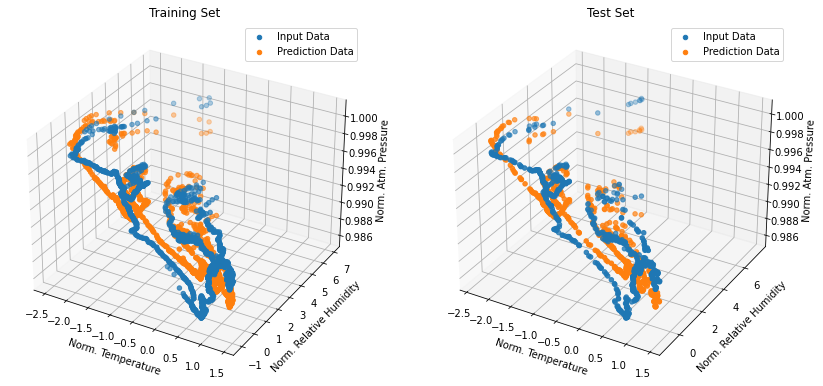

In [76]:
fig = plt.figure(figsize=(14,18))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X_training[:,0], X_training[:,1], Y_training, label="Input Data")
ax1.scatter(X_training[:,0], X_training[:,1], prediction_training, label="Prediction Data")
ax1.set_xlabel("Norm. Temperature")
ax1.set_ylabel("Norm. Relative Humidity")
ax1.set_zlabel("Norm. Atm. Pressure")
ax1.set_title("Training Set")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X_test[:,0], X_test[:,1], Y_test, label="Input Data")
ax2.scatter(X_test[:,0], X_test[:,1], prediction_test, label="Prediction Data")
ax2.set_xlabel("Norm. Temperature")
ax2.set_ylabel("Norm. Relative Humidity")
ax2.set_zlabel("Norm. Atm. Pressure")
ax2.set_title("Test Set")
ax2.legend()
plt.show()

## Ordinary Least-Squares using scikit-learn
Another fast way to compute the LS estimate is through sklearn.linear_model

In [78]:
LinReg = linear_model.LinearRegression()  # build the object LinearRegression
LinReg.fit(X_training, Y_training)  # estimate the LS coefficients
print("Intercept:", LinReg.intercept_)
print("Least-Squares Coefficients:", LinReg.coef_)
prediction_training = LinReg.predict(X_training)  # predict output values on training set
prediction_test = LinReg.predict(X_test)  # predict output values on test set
print("Measure on training data:", 1-LinReg.score(X_training, Y_training))
print("Measure on test data:", 1-LinReg.score(X_test, Y_test))

Intercept: 0.9930407637182382
Least-Squares Coefficients: [-0.00318278 -0.000108  ]
Measure on training data: 0.3717942539349356
Measure on test data: 0.3459060257485793


In [79]:
RSS_training = np.linalg.norm(Y_training - prediction_training)**2
RSS_test     = np.linalg.norm(Y_test - prediction_test)**2

print("RSS on training set: ", RSS_training)
print("Loss estimate on training set: ", RSS_training/m_training)

print("RSS on test data:",  RSS_test)
print("Loss estimated from test data:", RSS_test/m_test)

RSS on training set:  0.00890795366502286
Loss estimate on training set:  5.848951848340683e-06
RSS on test data: 0.00359565528401269
Loss estimated from test data: 5.497943859346621e-06


Results obtained using `sklearn.linear_model.LinearRegression()` agree with the ones we obtained with `np.linalg.lstsq()` few cells above.